# Predicting Engineer Salaries
###### Quevico competition

###### Ho Van Nghiem

28/08/2020

* #### 1. Introduction
* #### 2. Load and check data
* #### 3. Salaries analysis
* #### 4. Imputing missing values
    * 4.1 Fill missing value on numeric columns
    * 4.2 Fill missing value on categorical columns
* #### 5. Feature Engineering
    * 5.1 Categorical multiple-choices
    * 5.2 Categorical option-choices
        * 5.2.1 Ordered variables
        * 5.2.2 Non Ordered variables
    * 5.3 Normalization
* #### 6. Modeling
    * 6.1 Simple model
        * 6.1.1 Fine tuning parameter
        * 6.1.2 Features coefftion
    * 6.2 Trees based model
        * 6.2.1 Fine tuning XGBoost parameter
        * 6.2.2 Fine tuning LighGBM parameter
    * 6.3 Voting

## 1. Introduction
Understanding what’s inside the heads of engineers who have high salaries

The task in this competition involves the use of regression analysis. The goal is to predict the salaries of engineers using a survey consisting of over 100 questions administered to over 90,000 engineers by Stack Overflow in 2018. The survey includes a wide range of questions including the respondents’ history, skills, and thoughts on machine learning.

This competition to introduce to regression techniques and data tranformation. Firstly, I will display some feature analysis then i'll focus on feature transformation/engineering. Last part concerns modeling and prediction of engineer salary using an ensemble procedure.

##### This script follows four main parts:

* Data correction
* SalePrice analysis
* Feature engineering
* Modeling

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
import numpy as np
import pandas as pd 

from pandas.api.types import CategoricalDtype
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNetCV
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import VotingRegressor
import xgboost as xgb
import lightgbm as lgb
import itertools

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
sns.set(style='white', context='notebook', palette='deep')
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 2. Load and check data

In [3]:
#View the question data
question_data = pd.read_csv('/content/gdrive/My Drive/Python/Final project/Predict Engineer salary/data_all/question.csv')
print(question_data.shape)
question_data.head(5)

(129, 2)


,Column,QuestionText
0,Respondent,Randomized respondent ID number (not in order ...
1,Hobby,Do you code as a hobby?
2,OpenSource,Do you contribute to open source projects?
3,Country,In which country do you currently reside?
4,Student,"Are you currently enrolled in a formal, degree..."


In [4]:
#View the training data
train_data = pd.read_csv('/content/gdrive/My Drive/Python/Final project/Predict Engineer salary/data_all/train.csv')
print(train_data.shape)
train_data.head(5)

(33857, 128)


,No,Hobby,OpenSource,Country,Student,Employment,FormalEducation,UndergradMajor,CompanySize,DevType,YearsCoding,YearsCodingProf,JobSatisfaction,CareerSatisfaction,HopeFiveYears,JobSearchStatus,LastNewJob,AssessJob1,AssessJob2,AssessJob3,AssessJob4,AssessJob5,AssessJob6,AssessJob7,AssessJob8,AssessJob9,AssessJob10,AssessBenefits1,AssessBenefits2,AssessBenefits3,AssessBenefits4,AssessBenefits5,AssessBenefits6,AssessBenefits7,AssessBenefits8,AssessBenefits9,AssessBenefits10,AssessBenefits11,JobContactPriorities1,JobContactPriorities2,...,AdsPriorities4,AdsPriorities5,AdsPriorities6,AdsPriorities7,AIDangerous,AIInteresting,AIResponsible,AIFuture,EthicsChoice,EthicsReport,EthicsResponsible,EthicalImplications,StackOverflowRecommend,StackOverflowVisit,StackOverflowHasAccount,StackOverflowParticipate,StackOverflowJobs,StackOverflowDevStory,StackOverflowJobsRecommend,StackOverflowConsiderMember,HypotheticalTools1,HypotheticalTools2,HypotheticalTools3,HypotheticalTools4,HypotheticalTools5,WakeTime,HoursComputer,HoursOutside,SkipMeals,ErgonomicDevices,Exercise,Gender,SexualOrientation,EducationParents,RaceEthnicity,Age,Dependents,MilitaryUS,SurveyTooLong,SurveyEasy
0,1,Yes,No,Nigeria,No,"Independent contractor, freelancer, or self-em...","Bachelor’s degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...",NaN,Database administrator;Designer;Full-stack dev...,18-20 years,6-8 years,Slightly satisfied,Extremely satisfied,Working as a founder or co-founder of my own c...,"I’m not actively looking, but I am open to new...",Between 1 and 2 years ago,9.0,7.0,8.0,3.0,6.0,10.0,2.0,1.0,5.0,4.0,1.0,10.0,5.0,9.0,11.0,2.0,7.0,6.0,8.0,4.0,3.0,1.0,2.0,...,6.0,2.0,3.0,7.0,Increasing automation of jobs,Algorithms making important decisions,The developers or the people creating the AI,I'm excited about the possibilities more than ...,No,"Yes, but only within the company",Upper management at the company/organization,Yes,10 (Very Likely),Multiple times per day,Yes,A few times per month or weekly,"No, I didn't know that Stack Overflow had a jo...","No, and I don't know what that is",NaN,Yes,Extremely interested,Extremely interested,Extremely interested,Extremely interested,Extremely interested,Between 5:00 - 6:00 AM,5 - 8 hours,Over 4 hours,3 - 4 times per week,NaN,I don't typically exercise,Male,Straight or heterosexual,"Bachelor’s degree (BA, BS, B.Eng., etc.)",Black or of African descent,35 - 44 years old,Yes,NaN,The survey was too long,Somewhat easy
1,2,Yes,Yes,France,No,Employed full-time,"Master’s degree (MA, MS, M.Eng., MBA, etc.)","A natural science (ex. biology, chemistry, phy...","10,000 or more employees",Back-end developer,18-20 years,18-20 years,Extremely satisfied,Extremely satisfied,Doing the same work,I am not interested in new job opportunities,Between 2 and 4 years ago,9.0,2.0,1.0,6.0,4.0,8.0,3.0,5.0,10.0,7.0,2.0,7.0,3.0,6.0,11.0,8.0,10.0,1.0,4.0,9.0,5.0,NaN,NaN,...,7.0,4.0,6.0,5.0,"Evolving definitions of ""fairness"" in algorith...",Increasing automation of jobs,The developers or the people creating the AI,I'm worried about the dangers more than I'm ex...,No,"Yes, but only within the company",The developer who wrote it,Yes,8,Daily or almost daily,Yes,A few times per week,"No, I knew that Stack Overflow had a jobs boar...","No, and I don't know what that is",NaN,Yes,Very interested,Somewhat interested,A little bit interested,A little bit interested,A little bit interested,Between 7:01 - 8:00 AM,Over 12 hours,30 - 59 minutes,Never,Ergonomic keyboard or mouse,I don't typically exercise,Male,Straight or heterosexual,"Master’s degree (MA, MS, M.Eng., MBA, etc.)",White or of European descent,35 - 44 years old,Yes,NaN,The survey was too long,Somewhat easy
2,3,Yes,Yes,United Kingdom,No,Employed full-time,Some college/university study without earning ...,"Computer science, computer engineering, or sof...",NaN,Designer;Full-stack developer,27-29 years,15-17 years,Extremely satisfied,Moderately satisfied,Working in a differ

In [5]:
#View the test data
test_data = pd.read_csv('/content/gdrive/My Drive/Python/Final project/Predict Engineer salary/data_all/test.csv')
print(test_data.shape)
test_data.head(5)

(11259, 127)


,No,Hobby,OpenSource,Country,Student,Employment,FormalEducation,UndergradMajor,CompanySize,DevType,YearsCoding,YearsCodingProf,JobSatisfaction,CareerSatisfaction,HopeFiveYears,JobSearchStatus,LastNewJob,AssessJob1,AssessJob2,AssessJob3,AssessJob4,AssessJob5,AssessJob6,AssessJob7,AssessJob8,AssessJob9,AssessJob10,AssessBenefits1,AssessBenefits2,AssessBenefits3,AssessBenefits4,AssessBenefits5,AssessBenefits6,AssessBenefits7,AssessBenefits8,AssessBenefits9,AssessBenefits10,AssessBenefits11,JobContactPriorities1,JobContactPriorities2,...,AdsPriorities4,AdsPriorities5,AdsPriorities6,AdsPriorities7,AIDangerous,AIInteresting,AIResponsible,AIFuture,EthicsChoice,EthicsReport,EthicsResponsible,EthicalImplications,StackOverflowRecommend,StackOverflowVisit,StackOverflowHasAccount,StackOverflowParticipate,StackOverflowJobs,StackOverflowDevStory,StackOverflowJobsRecommend,StackOverflowConsiderMember,HypotheticalTools1,HypotheticalTools2,HypotheticalTools3,HypotheticalTools4,HypotheticalTools5,WakeTime,HoursComputer,HoursOutside,SkipMeals,ErgonomicDevices,Exercise,Gender,SexualOrientation,EducationParents,RaceEthnicity,Age,Dependents,MilitaryUS,SurveyTooLong,SurveyEasy
0,33858,No,No,United States,No,Employed full-time,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...",NaN,Back-end developer;Front-end developer;Full-st...,9-11 years,3-5 years,Neither satisfied nor dissatisfied,Slightly satisfied,Doing the same work,"I’m not actively looking, but I am open to new...",More than 4 years ago,9.0,8.0,6.0,3.0,1.0,5.0,4.0,2.0,10.0,7.0,1.0,7.0,3.0,10.0,5.0,6.0,8.0,2.0,11.0,9.0,4.0,3.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,33859,Yes,No,United States,No,Employed full-time,"Bachelor’s degree (BA, BS, B.Eng., etc.)",NaN,100 to 499 employees,Back-end developer;Database administrator;DevO...,3-5 years,3-5 years,Extremely satisfied,Extremely satisfied,Doing the same work,"I’m not actively looking, but I am open to new...",Less than a year ago,10.0,4.0,9.0,1.0,2.0,8.0,7.0,3.0,6.0,5.0,1.0,10.0,2.0,8.0,11.0,4.0,7.0,6.0,5.0,9.0,3.0,2.0,1.0,...,5.0,7.0,4.0,2.0,Artificial intelligence surpassing human intel...,Increasing automation of jobs,The developers or the people creating the AI,I'm excited about the possibilities more than ...,Depends on what it is,Depends on what it is,Upper management at the company/organization,Yes,10 (Very Likely),Multiple times per day,Yes,Multiple times per day,Yes,"No, I have one but it's out of date",10 (Very Likely),Yes,Somewhat interested,Very interested,Very interested,Extremely interested,Extremely interested,Between 5:00 - 6:00 AM,9 - 12 hours,1 - 2 hours,Never,NaN,Daily or almost every day,Male,Straight or heterosexual,"Master’s degree (MA, MS, M.Eng., MBA, etc.)",White or of European descent,25 - 34 years old,Yes,No,The survey was an appropriate length,Very easy
2,33860,Yes,No,United States,No,Employed full-time,"Bachelor’s degree (BA, BS, B.Eng., etc.)","A natural science (ex. biology, chemistry, phy...",20 to 99 employees,Front-end developer;Full-stack developer,3-5 years,0-2 years,Slightly satisfied,Slightly satisfied,Working as an engineering manager or other fun...,I am not interested in new job opportunities,Less than a year ago,4.0,8.0,10.0,6.0,3.0,1.0,9.0,7.0,2.0,5.0,1.0,4.0,2.0,6.0,10.0,3.0,5.0,8.0,9.0,7.0,11.0,NaN,NaN,...,4.0,3.0,7.0,5.0,Increasing automation of jobs,Increasing automation of jobs,The developers or the people creating the AI,I'm excited about the possibilities more than ...,No,Depends on what it is,Upper management at the company/organization,Yes,10 (Very Likely),Multiple times per day,Yes,A few times per week,Yes,"No, I have one but it's out of date",7,I'm not sure,Somewhat interested,Somewhat interested,Very interested,Very interested,Extremely interested,Between 7:01 - 8:00 AM,9 - 12 hours,30 - 59 minutes,Never,Ergonomic key

In [6]:
# Number of each type of column
train_data.dtypes.value_counts()

object     86
float64    41
int64       1
dtype: int64

In [7]:
#42 numeric features
train_data.select_dtypes(include=['int64','float64']).columns

Index(['No', 'AssessJob1', 'AssessJob2', 'AssessJob3', 'AssessJob4',
       'AssessJob5', 'AssessJob6', 'AssessJob7', 'AssessJob8', 'AssessJob9',
       'AssessJob10', 'AssessBenefits1', 'AssessBenefits2', 'AssessBenefits3',
       'AssessBenefits4', 'AssessBenefits5', 'AssessBenefits6',
       'AssessBenefits7', 'AssessBenefits8', 'AssessBenefits9',
       'AssessBenefits10', 'AssessBenefits11', 'JobContactPriorities1',
       'JobContactPriorities2', 'JobContactPriorities3',
       'JobContactPriorities4', 'JobContactPriorities5', 'JobEmailPriorities1',
       'JobEmailPriorities2', 'JobEmailPriorities3', 'JobEmailPriorities4',
       'JobEmailPriorities5', 'JobEmailPriorities6', 'JobEmailPriorities7',
       'Salary', 'AdsPriorities1', 'AdsPriorities2', 'AdsPriorities3',
       'AdsPriorities4', 'AdsPriorities5', 'AdsPriorities6', 'AdsPriorities7'],
      dtype='object')

In [8]:
#86 categorical features
train_data.select_dtypes(include=['object']).columns

Index(['Hobby', 'OpenSource', 'Country', 'Student', 'Employment',
       'FormalEducation', 'UndergradMajor', 'CompanySize', 'DevType',
       'YearsCoding', 'YearsCodingProf', 'JobSatisfaction',
       'CareerSatisfaction', 'HopeFiveYears', 'JobSearchStatus', 'LastNewJob',
       'UpdateCV', 'Currency', 'SalaryType', 'CurrencySymbol',
       'CommunicationTools', 'TimeFullyProductive', 'EducationTypes',
       'SelfTaughtTypes', 'TimeAfterBootcamp', 'HackathonReasons',
       'AgreeDisagree1', 'AgreeDisagree2', 'AgreeDisagree3',
       'LanguageWorkedWith', 'LanguageDesireNextYear', 'DatabaseWorkedWith',
       'DatabaseDesireNextYear', 'PlatformWorkedWith',
       'PlatformDesireNextYear', 'FrameworkWorkedWith',
       'FrameworkDesireNextYear', 'IDE', 'OperatingSystem', 'NumberMonitors',
       'Methodology', 'VersionControl', 'CheckInCode', 'AdBlocker',
       'AdBlockerDisable', 'AdBlockerReasons', 'AdsAgreeDisagree1',
       'AdsAgreeDisagree2', 'AdsAgreeDisagree3', 'AdsActions',

In [9]:
# we drop No feature
train_data = train_data.drop(labels = ["No"],axis = 1)
test_data = test_data.drop(labels = ["No"],axis = 1)

## 3. Salaries analysis

In [10]:
train_data['Salary'].describe()

count     33857.000000
mean      58960.822459
std       44194.201640
min           0.000000
25%       22452.000000
50%       52089.000000
75%       85000.000000
max      280000.000000
Name: Salary, dtype: float64

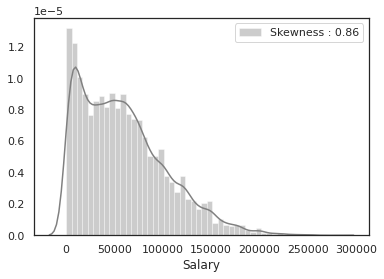

In [11]:
g = sns.distplot(train_data['Salary'],color="gray")
g = g.legend(['Skewness : {:.2f}'.format(train_data['Salary'].skew())],loc='best')

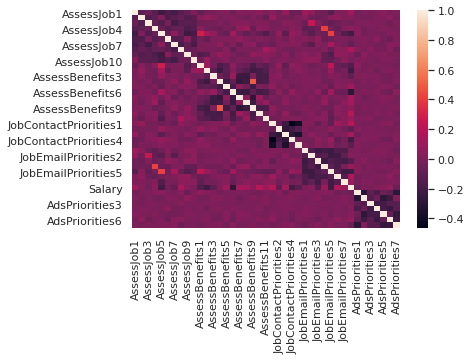

In [12]:
#Explore correlation
corrmat = train_data.corr()
g = sns.heatmap(train_data.corr())

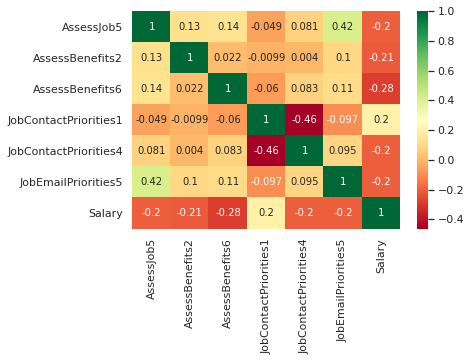

In [13]:
# most correlated features
top_corr_features = corrmat.index[abs(corrmat['Salary'])>0.2]
g = sns.heatmap(train_data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

Let's explore the relationship between the top correlated feature with Salary.

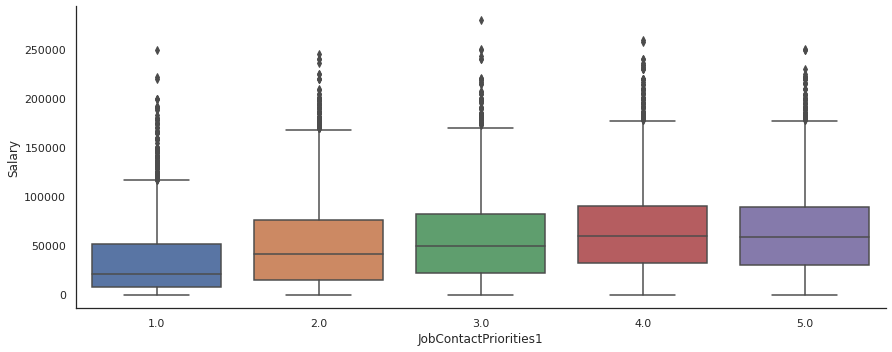

In [14]:
g = sns.factorplot(x='JobContactPriorities1',y="Salary",data=train_data,kind='box',aspect=2.5)

In [15]:
# what's AssessBenefits6
idx=pd.Index(question_data['Column']).get_loc('JobContactPriorities1')
question_data['QuestionText'][idx]

'Imagine that a company wanted to contact you about a job that is a good fit for you. Please rank your preference in how you are contacted (by dragging the choices up and down), where 1 is the most preferred and 5 is the least preferred. Telephone call'

In [16]:
#function to plot multiple chart
def multiplot(data,features,plottype,nrows,ncols,figsize,y=None,colorize=False):
    """ This function draw a multi plot for 3 types of plots ["regplot","distplot","coutplot"]"""
    n = 0
    plt.figure(1)
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    
    if colorize:
        colors = sns.color_palette(n_colors=(nrows*ncols))
    else :
        colors = [None]*(nrows*ncols)
        
    for row in range(ncols):
        for col in range(nrows):
            
            if plottype == 'regplot':
                if y == None:
                    raise ValueError('y value is needed with regplot type')
                
                sns.regplot(data = data, x = features[n], y = y ,ax=axes[row,col], color = colors[n])
                correlation = np.corrcoef(data[features[n]],data[y])[0,1]
                axes[row,col].set_title("Correlation {:.2f}".format(correlation))
            
            elif plottype == 'distplot':
                sns.distplot(a = data[features[n]],ax = axes[row,col],color=colors[n])
                skewness = data[features[n]].skew()
                axes[row,col].legend(["Skew : {:.2f}".format(skewness)])
            
            elif plottype in ['countplot']:
                g = sns.countplot(x = data[features[n]], y = y, ax = axes[row,col],color = colors[n])
                g = plt.setp(g.get_xticklabels(), rotation=45)
                
            n += 1
    plt.tight_layout()
    plt.show()
    plt.gcf().clear()

<Figure size 432x288 with 0 Axes>

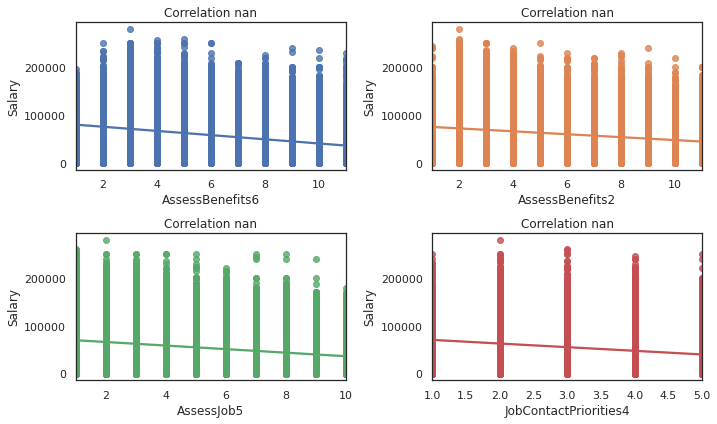

<Figure size 432x288 with 0 Axes>

In [17]:
feats = ["AssessBenefits6",'AssessBenefits2','AssessJob5','JobContactPriorities4']

multiplot(data = train_data,features = feats,plottype = "regplot",nrows = 2, ncols = 2,
          figsize = (10,6),y = "Salary", colorize = True)

It seems to be no correlation, these features look like an ordinal variable, not continuous

## 4. Imputing missing values

In [18]:
## Join train and test datasets in order to avoid obtain the same number of feature during categorical conversion
train_len = len(train_data)
target = train_data['Salary']
train_data=train_data.drop('Salary',axis=1)
dataset =  pd.concat(objs=[train_data, test_data], axis=0).reset_index(drop=True)

In [20]:
dataset.shape

(45116, 126)

In [21]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [22]:
missing_values = missing_values_table(dataset)
missing_values.head(10)

Your selected dataframe has 126 columns.
There are 122 columns that have missing values.


,Missing Values,% of Total Values
TimeAfterBootcamp,40858,90.6
MilitaryUS,33409,74.1
HackathonReasons,27957,62.0
ErgonomicDevices,24809,55.0
AdBlockerReasons,21867,48.5
StackOverflowJobsRecommend,20363,45.1
JobEmailPriorities5,14445,32.0
JobEmailPriorities7,14445,32.0
JobEmailPriorities6,14445,32.0
JobEmailPriorities4,14445,32.0


In [23]:
#drop the column has ~90 percent missing
dataset = dataset.drop(labels = ["TimeAfterBootcamp"],axis = 1)

### 4.1 Fill missing for numeric columns

In [24]:
numeric_columns=dataset.select_dtypes(include=['int64','float64']).columns

In [25]:
missing_features_numeric = numeric_columns[dataset[numeric_columns].isnull().any()]
missing_features_numeric

Index(['AssessJob1', 'AssessJob2', 'AssessJob3', 'AssessJob4', 'AssessJob5',
       'AssessJob6', 'AssessJob7', 'AssessJob8', 'AssessJob9', 'AssessJob10',
       'AssessBenefits1', 'AssessBenefits2', 'AssessBenefits3',
       'AssessBenefits4', 'AssessBenefits5', 'AssessBenefits6',
       'AssessBenefits7', 'AssessBenefits8', 'AssessBenefits9',
       'AssessBenefits10', 'AssessBenefits11', 'JobContactPriorities1',
       'JobContactPriorities2', 'JobContactPriorities3',
       'JobContactPriorities4', 'JobContactPriorities5', 'JobEmailPriorities1',
       'JobEmailPriorities2', 'JobEmailPriorities3', 'JobEmailPriorities4',
       'JobEmailPriorities5', 'JobEmailPriorities6', 'JobEmailPriorities7',
       'AdsPriorities1', 'AdsPriorities2', 'AdsPriorities3', 'AdsPriorities4',
       'AdsPriorities5', 'AdsPriorities6', 'AdsPriorities7'],
      dtype='object')

<Figure size 432x288 with 0 Axes>

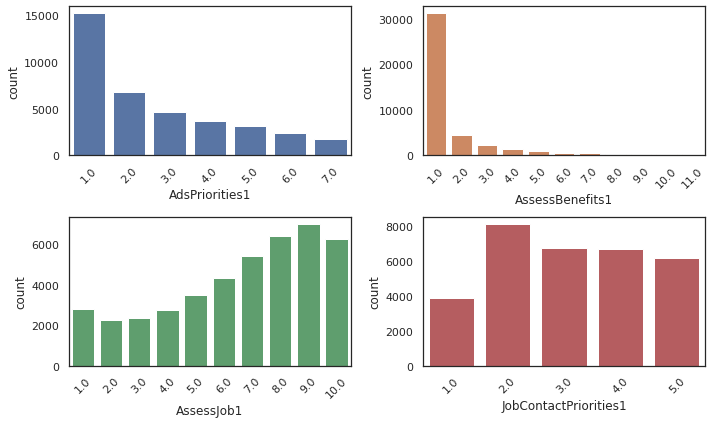

<Figure size 432x288 with 0 Axes>

In [26]:
numeric_feats = ["AdsPriorities1",'AssessBenefits1','AssessJob1','JobContactPriorities1']

multiplot(data = dataset,features = numeric_feats,plottype = "countplot",nrows = 2, ncols = 2,
          figsize = (10,6), colorize = True)

These numeric columns are an ordinal variable, so we fill missing by most frequent values

In [27]:
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
numeric_arr = imputer.fit_transform(dataset[missing_features_numeric])

In [28]:
for i,col in enumerate(missing_features_numeric):
    dataset[col]=numeric_arr[:,i]

<Figure size 432x288 with 0 Axes>

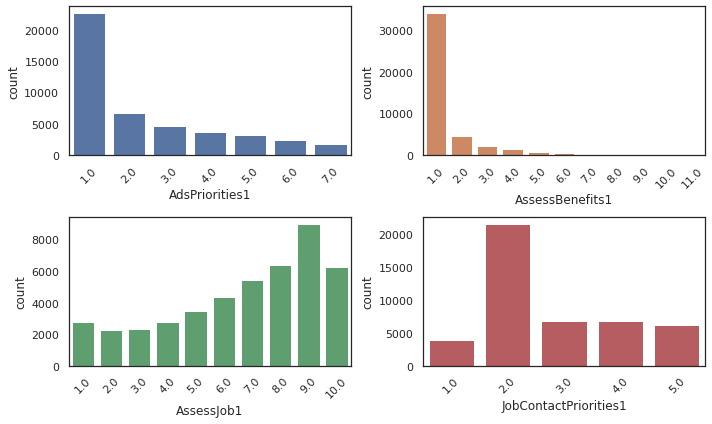

<Figure size 432x288 with 0 Axes>

In [29]:
#explore numeric data after fill missing
numeric_feats = ["AdsPriorities1",'AssessBenefits1','AssessJob1','JobContactPriorities1']

multiplot(data = dataset,features = numeric_feats,plottype = "countplot",nrows = 2, ncols = 2,
          figsize = (10,6), colorize = True)

### 4.2 Fill missing for categorical columns

In [30]:
categorical_columns=dataset.select_dtypes(include=['object']).columns
len(categorical_columns)

85

In [31]:
#the columns have missing value on categorical variable
missing_features_categorical = categorical_columns[dataset[categorical_columns].isnull().any()]
missing_features_categorical

Index(['Student', 'Employment', 'FormalEducation', 'UndergradMajor',
       'CompanySize', 'DevType', 'YearsCoding', 'YearsCodingProf',
       'JobSatisfaction', 'CareerSatisfaction', 'HopeFiveYears',
       'JobSearchStatus', 'LastNewJob', 'UpdateCV', 'Currency', 'SalaryType',
       'CommunicationTools', 'TimeFullyProductive', 'EducationTypes',
       'SelfTaughtTypes', 'HackathonReasons', 'AgreeDisagree1',
       'AgreeDisagree2', 'AgreeDisagree3', 'LanguageWorkedWith',
       'LanguageDesireNextYear', 'DatabaseWorkedWith',
       'DatabaseDesireNextYear', 'PlatformWorkedWith',
       'PlatformDesireNextYear', 'FrameworkWorkedWith',
       'FrameworkDesireNextYear', 'IDE', 'OperatingSystem', 'NumberMonitors',
       'Methodology', 'VersionControl', 'CheckInCode', 'AdBlocker',
       'AdBlockerDisable', 'AdBlockerReasons', 'AdsAgreeDisagree1',
       'AdsAgreeDisagree2', 'AdsAgreeDisagree3', 'AdsActions', 'AIDangerous',
       'AIInteresting', 'AIResponsible', 'AIFuture', 'EthicsChoi

In [32]:
#Explore number of category on each columns
dataset[missing_features_categorical].apply(pd.Series.nunique, axis = 0).sort_values(ascending=False).head(20)

LanguageDesireNextYear     18373
LanguageWorkedWith         16994
PlatformDesireNextYear      9236
DatabaseDesireNextYear      6923
PlatformWorkedWith          6422
DevType                     5921
IDE                         5429
DatabaseWorkedWith          5036
FrameworkDesireNextYear     1397
CommunicationTools          1004
FrameworkWorkedWith          810
EducationTypes               472
SelfTaughtTypes              431
Methodology                  420
HackathonReasons             127
VersionControl                84
AdBlockerReasons              63
RaceEthnicity                 60
Currency                      19
Gender                        15
dtype: int64

There are too many categories on those features. So we will go to inside that and see what is it 

In [33]:
dataset['LanguageDesireNextYear'].head(5)

0                   C#;Java;PHP;Python;SQL;HTML;CSS
1                                    Go;Java;Kotlin
2                                           Haskell
3                                    Assembly;C;C++
4    C++;C#;Java;JavaScript;PHP;Python;SQL;HTML;CSS
Name: LanguageDesireNextYear, dtype: object

It is delimited by ";". Maybe that comes from the question has multiple-choices answers.

We will count the number of that kind of types

In [34]:
#function for check which column contains multiple-choice
def check_multiple_choices(text):
    if type(text)==str:
        if ';' in text:
            return True
        else:
            return False
    return False

In [35]:
categorical_columns
mul_choices_cols_name=[]
for i in categorical_columns:
    if sum(dataset[i].apply(check_multiple_choices))>0:
        mul_choices_cols_name.append(i)

In [36]:
# the columns belong to multiple-choices categorical
len(mul_choices_cols_name)

22

We will come back to these columns on session Feature Engineering. Now we focus on the rest of categorical that we call option-choices 

In [37]:
option_choices_columns=[col for col in categorical_columns if col not in mul_choices_cols_name]

In [38]:
len(option_choices_columns)

63

In [39]:
dataset[option_choices_columns].isnull().sum(axis=0).sort_values(ascending=False).head(5)

MilitaryUS                    33409
StackOverflowJobsRecommend    20363
AdBlockerDisable              12340
TimeFullyProductive            7414
AIDangerous                    6857
dtype: int64

In [40]:
dataset[option_choices_columns].isnull().sum(axis=0).sort_values(ascending=False).tail(5)

JobSearchStatus    1
OpenSource         0
CurrencySymbol     0
Country            0
Hobby              0
dtype: int64

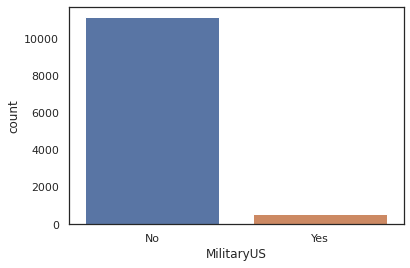

In [41]:
g = sns.countplot(dataset["MilitaryUS"])

fill the missing by most frequent values

In [42]:
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
category_arr = imputer.fit_transform(dataset[option_choices_columns])

In [43]:
for i,col in enumerate(option_choices_columns):
    dataset[col]=category_arr[:,i]

## 5. Feature Engineering

### 5.1. Categorical multiple-choices

Due to the values on these columns is delimited by ";", so we need to transform it into the dummy variable

In [44]:
#function for encoding multiple-choice to one hot
def encode(ls,ref):
    ini_vec = np.zeros((len(ref)))
    ini_ls=[]
    for i in ls:
        ini_ls.append(ref.index(i))
    ini_vec[ini_ls]=1
    return ini_vec.astype('int')

In [45]:
#function for count the number of choices on each column
def count_multiple_choice(text):
    if type(text)==str:
        return text.split(";")
    else:
        return []

In [46]:
#apply the function to handle multiple-choices columns
ls_v4_train=[]
ls_v2=[]
for c in mul_choices_cols_name:
    
    v1_train = dataset[c].apply(count_multiple_choice) #series
    
    v2 = list(set(list(itertools.chain(*v1_train)))) #list of unique of multiple-choices
    v3_train = v1_train.apply(encode,ref=v2) #numpy array
    
    v4_train = np.concatenate(v3_train.values).reshape(-1,len(v2))

    ls_v4_train.append(v4_train)

    ls_v2.append(v2)
v5_train = np.concatenate(ls_v4_train,axis=1)

v6 = list(itertools.chain(*ls_v2))
multi_choice_dataset = pd.DataFrame(v5_train,columns = v6)


In [47]:
multi_choice_dataset.head(5)

,Designer,Desktop or enterprise applications developer,Embedded applications or devices developer,Data scientist or machine learning specialist,Full-stack developer,Front-end developer,"C-suite executive (CEO, CTO, etc.)",Mobile developer,Student,Marketing or sales professional,Engineering manager,System administrator,Product manager,Database administrator,Game or graphics developer,Educator or academic researcher,QA or test developer,Back-end developer,DevOps specialist,Data or business analyst,Facebook,"Other chat system (IRC, proprietary software, etc.)",Trello,Jira,"Office / productivity suite (Microsoft Office, Google Suite, etc.)",Google Hangouts/Chat,"Other wiki tool (Github, Google Sites, proprietary software, etc.)",Stack Overflow Enterprise,HipChat,Slack,Confluence,Completed an industry certification program (e.g. MCPD),Received on-the-job training in software development,Participated in a hackathon,Contributed to open source software,Participated in a full-time developer training program or bootcamp,"Participated in online coding competitions (e.g. HackerRank, CodeChef, TopCoder)","Taught yourself a new language, framework, or tool without taking a formal course",Taken a part-time in-person course in programming or software development,Taken an online course in programming or software development (e.g. a MOOC),...,Mob programming,Agile,Kanban,Evidence-based software engineering,I don't use version control,Team Foundation Version Control,Git,Copying and pasting files to network shares,Zip file back-ups,Subversion,Mercurial,I wanted to support the website I was visiting by viewing their ads,The website I was visiting has interesting ads,I wanted to view a specific advertisement,The ad-blocking software was causing display issues on a website,The website I was visiting forced me to disable it to access their content,The website I was visiting asked me to disable it,Clicked on an online advertisement,Paid to access a website advertisement-free,Stopped going to a website because of their advertising,Saw an online advertisement and then researched it (without clicking on the ad),Ergonomic keyboard or mouse,Wrist/hand supports or braces,Fatigue-relieving floor mat,Standing desk,Female,"Non-binary, genderqueer, or gender non-conforming",Male,Transgender,Bisexual or Queer,Asexual,Gay or Lesbian,Straight or heterosexual,Middle Eastern,South Asian,East Asian,Hispanic or Latino/Latina,Black or of African descent,White or of European descent,"Native American, Pacific Islander, or Indigenous Australian"
0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0,1,1,1,1,1,0,1,0,0,1,1,1,...,0,1,1,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0
2,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,...,0,1,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0
3,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,1,0,1,...,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0


In [48]:
len(multi_choice_dataset.columns)

320

In [49]:
#rebuild dataset
temp = dataset.drop(mul_choices_cols_name,axis=1)
dataset = pd.concat(objs=[temp, multi_choice_dataset], axis=1)

In [50]:
dataset.shape

(45116, 423)

### 5.2 Categorical option-choices

#### 5.2.1 Ordered variables

Ordered categorical features, for example this kernel is ("Very bad", "Bad", "okay", "Good", "Amazing") need to be encoded as numerical ordered values (0->4 for example).

In [51]:
Ordered_feats=['YearsCodingProf','YearsCoding','StackOverflowRecommend','StackOverflowJobsRecommend','CompanySize',
              'CareerSatisfaction','Age','CheckInCode','StackOverflowParticipate','TimeFullyProductive','StackOverflowVisit',
              'SurveyEasy','AgreeDisagree3','NumberMonitors','LastNewJob','AgreeDisagree2','AgreeDisagree1','AdsAgreeDisagree1',
              'AdsAgreeDisagree2','AdsAgreeDisagree3','HypotheticalTools1','HypotheticalTools2','HypotheticalTools3','HypotheticalTools4',
              'HypotheticalTools5','HoursComputer','HoursOutside','SkipMeals','Exercise','SurveyTooLong','FormalEducation','EducationParents','Country']

In [52]:
# Categorical values
# Ordered
cat_type_1 = CategoricalDtype(categories=['0-2 years', '3-5 years','6-8 years','9-11 years','12-14 years','15-17 years','18-20 years',
                                        '21-23 years','24-26 years','27-29 years','30 or more years'], ordered=True)
dataset['YearsCodingProf']=dataset['YearsCodingProf'].astype(cat_type_1).cat.codes

cat_type_2 = CategoricalDtype(categories=['0-2 years', '3-5 years','6-8 years','9-11 years','12-14 years',
                                       '15-17 years','18-20 years','21-23 years','24-26 years','27-29 years','30 or more years'],ordered=True)
dataset['YearsCoding']=dataset['YearsCoding'].astype(cat_type_2).cat.codes

cat_type_3 = CategoricalDtype(categories=['0 (Not Likely)', '1','2','3','4','5','6','7','8','9','10 (Very Likely)'],ordered=True)
dataset['StackOverflowRecommend']=dataset['StackOverflowRecommend'].astype(cat_type_3).cat.codes
dataset['StackOverflowJobsRecommend']=dataset['StackOverflowJobsRecommend'].astype(cat_type_3).cat.codes

cat_type_4 = CategoricalDtype(categories=['Fewer than 10 employees', '10 to 19 employees','20 to 99 employees','100 to 499 employees','500 to 999 employees',
                                          '1,000 to 4,999 employees','5,000 to 9,999 employees','10,000 or more employees'],ordered=True)
dataset['CompanySize']=dataset['CompanySize'].astype(cat_type_4).cat.codes

cat_type_5 = CategoricalDtype(categories=['Extremely dissatisfied', 'Moderately dissatisfied','Slightly dissatisfied','Neither satisfied nor dissatisfied',
                                          'Slightly satisfied','Moderately satisfied','Extremely satisfied'],ordered=True)
dataset['CareerSatisfaction']=dataset['CareerSatisfaction'].astype(cat_type_5).cat.codes

cat_type_6 = CategoricalDtype(categories=['Under 18 years old', '18 - 24 years old','25 - 34 years old','35 - 44 years old','45 - 54 years old',
                                           '55 - 64 years old','65 years or older'],ordered=True)
dataset['Age']=dataset['Age'].astype(cat_type_6).cat.codes

cat_type_7 = CategoricalDtype(categories=['Never', 'Less than once per month','Weekly or a few times per month','A few times per week',
                                          'Once a day','Multiple times per day'],ordered=True)
dataset['CheckInCode']=dataset['CheckInCode'].astype(cat_type_7).cat.codes

cat_type_8 = CategoricalDtype(categories=['I have never participated in Q&A on Stack Overflow', 'Less than once per month or monthly','A few times per month or weekly',
                                          'A few times per week','Daily or almost daily','Multiple times per day'],ordered=True)
dataset['StackOverflowParticipate']=dataset['StackOverflowParticipate'].astype(cat_type_8).cat.codes

cat_type_9 = CategoricalDtype(categories=['Less than a month', 'One to three months','Three to six months','Six to nine months',
                                           'Nine months to a year','More than a year'],ordered=True)
dataset['TimeFullyProductive']=dataset['TimeFullyProductive'].astype(cat_type_9).cat.codes

cat_type_10 = CategoricalDtype(categories=['I have never visited Stack Overflow (before today)', 'Less than once per month or monthly','A few times per month or weekly',
                                           'A few times per week','Daily or almost daily','Multiple times per day'],ordered=True)
dataset['StackOverflowVisit']=dataset['StackOverflowVisit'].astype(cat_type_10).cat.codes

cat_type_11 = CategoricalDtype(categories=['Very easy', 'Somewhat easy','Neither easy nor difficult','Somewhat difficult',
                                            'Very difficult'],ordered=True)
dataset['SurveyEasy']=dataset['SurveyEasy'].astype(cat_type_11).cat.codes

cat_type_12 = CategoricalDtype(categories=['Strongly disagree', 'Disagree','Neither Agree nor Disagree','Agree',
                                            'Strongly agree'],ordered=True)
dataset['AgreeDisagree3']=dataset['AgreeDisagree3'].astype(cat_type_12).cat.codes

cat_type_13 = CategoricalDtype(categories=['1', '2','3','4','More than 4'],ordered=True)
dataset['NumberMonitors']=dataset['NumberMonitors'].astype(cat_type_13).cat.codes

cat_type_14 = CategoricalDtype(categories=['I\'ve never had a job', 'Less than a year ago','Between 1 and 2 years ago','Between 2 and 4 years ago',
                                           'More than 4 years ago'],ordered=True)
dataset['LastNewJob']=dataset['LastNewJob'].astype(cat_type_14).cat.codes

cat_type_15 = CategoricalDtype(categories=['Strongly disagree', 'Disagree','Neither Agree nor Disagree','Agree','Strongly agree'],ordered=True)
dataset['AgreeDisagree2']=dataset['AgreeDisagree2'].astype(cat_type_15).cat.codes

cat_type_16 = CategoricalDtype(categories=['Strongly disagree', 'Disagree','Neither Agree nor Disagree','Agree','Strongly agree'],ordered=True)
dataset['AgreeDisagree1']=dataset['AgreeDisagree1'].astype(cat_type_16).cat.codes

cat_type_17 = CategoricalDtype(categories=['Strongly disagree', 'Somewhat disagree','Neither agree nor disagree','Somewhat agree','Strongly agree'],ordered=True)
dataset['AdsAgreeDisagree1']=dataset['AdsAgreeDisagree1'].astype(cat_type_17).cat.codes
dataset['AdsAgreeDisagree2']=dataset['AdsAgreeDisagree2'].astype(cat_type_17).cat.codes
dataset['AdsAgreeDisagree3']=dataset['AdsAgreeDisagree3'].astype(cat_type_17).cat.codes

cat_type_18 = CategoricalDtype(categories=['Not at all interested', 'A little bit interested','Somewhat interested','Very interested',
                                           'Extremely interested'],ordered=True)
dataset['HypotheticalTools1']=dataset['HypotheticalTools1'].astype(cat_type_18).cat.codes
dataset['HypotheticalTools2']=dataset['HypotheticalTools2'].astype(cat_type_18).cat.codes
dataset['HypotheticalTools3']=dataset['HypotheticalTools3'].astype(cat_type_18).cat.codes
dataset['HypotheticalTools4']=dataset['HypotheticalTools4'].astype(cat_type_18).cat.codes
dataset['HypotheticalTools5']=dataset['HypotheticalTools5'].astype(cat_type_18).cat.codes

cat_type_19 = CategoricalDtype(categories=['Less than 1 hour', '1 - 4 hours','5 - 8 hours','9 - 12 hours','Over 12 hours'],ordered=True)
dataset['HoursComputer']=dataset['HoursComputer'].astype(cat_type_19).cat.codes

cat_type_20 = CategoricalDtype(categories=['Less than 30 minutes', '30 - 59 minutes','1 - 2 hours','3 - 4 hours','Over 4 hours'],ordered=True)
dataset['HoursOutside']=dataset['HoursOutside'].astype(cat_type_20).cat.codes

cat_type_21 = CategoricalDtype(categories=['Daily or almost every day', '3 - 4 times per week','1 - 2 times per week','Never'],ordered=True)
dataset['SkipMeals']=dataset['SkipMeals'].astype(cat_type_21).cat.codes

cat_type_22 = CategoricalDtype(categories=['I don\'t typically exercise', '1 - 2 times per week','3 - 4 times per week','Daily or almost every day'],ordered=True)                                                                                 
dataset['Exercise']=dataset['Exercise'].astype(cat_type_22).cat.codes

cat_type_23 = CategoricalDtype(categories=['The survey was too long', 'The survey was an appropriate length','The survey was too short'],ordered=True)
dataset['SurveyTooLong']=dataset['SurveyTooLong'].astype(cat_type_23).cat.codes

cat_type_24 = CategoricalDtype(categories=['I never completed any formal education', 'Primary/elementary school','Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)',
                                           'Some college/university study without earning a degree',
                                           'Associate degree','Bachelor’s degree (BA, BS, B.Eng., etc.)','Master’s degree (MA, MS, M.Eng., MBA, etc.)',
                                        'Professional degree (JD, MD, etc.)','Other doctoral degree (Ph.D, Ed.D., etc.)'],ordered=True)
dataset['FormalEducation']=dataset['FormalEducation'].astype(cat_type_24).cat.codes


cat_type_25 = CategoricalDtype(categories=['They never completed any formal education', 'Primary/elementary school','Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)',
                                           'Some college/university study without earning a degree',
                                           'Associate degree','Bachelor’s degree (BA, BS, B.Eng., etc.)','Master’s degree (MA, MS, M.Eng., MBA, etc.)',
                                        'Professional degree (JD, MD, etc.)','Other doctoral degree (Ph.D, Ed.D., etc.)'],ordered=True)
dataset['EducationParents']=dataset['EducationParents'].astype(cat_type_25).cat.codes

For "Country" feature it has about 152 categories. It probably makes overfitting if it is transformed into a dummy variable. So we bin it into 7 groups ordered it based on average salary

In [53]:
top1=['Botswana','Sierra Leone','United States','Qatar','Israel','Switzerland','Bahamas','Iceland','Denmark','Norway']
top2=['Ireland','United Kingdom','New Zealand','Canada','Oman','Luxembourg','Libyan Arab Jamahiriya','Germany','Sweden',
     'Finland','Netherlands','Japan','Austria','Singapore','Hong Kong (S.A.R.)']
top3=['Belgium','France','Andorra','United Arab Emirates','South Korea','Other Country (Not Listed Above)','South Africa',
     'Malta','Marshall Islands','Kuwait','Italy','Uruguay','Slovenia','Estonia','Costa Rica','Cyprus','Nicaragua']
top4=['Spain','Lesotho','Liechtenstein','Republic of Korea','Saudi Arabia','Democratic Republic of the Congo',
     'Madagascar','Czech Republic','Poland','Slovakia','Lithuania','Hungary','Romania','Chile','Latvia','Lebanon',
     'Thailand','Taiwan','Bulgaria','Croatia','Panama','Greece']
top5=['Portugal','China','Tajikistan','United Republic of Tanzania','Serbia','Turkey','Bosnia and Herzegovina','Argentina',
     'Cameroon','Armenia','The former Yugoslav Republic of Macedonia','Belarus','Benin','Zimbabwe','Guatemala','Cambodia',
     'Russian Federation','Morocco','Togo','Ecuador','Paraguay','Brazil','Ukraine','Jordan','Trinidad and Tobago','Dominican Republic',
     'Colombia','Mexico','Malaysia','Montenegro','Barbados','Peru','Kenya']
top6=['Republic of Moldova','Honduras','Azerbaijan','Senegal','Venezuela, Bolivarian Republic of...',
     'Suriname','El Salvador','Rwanda','Viet Nam','Kazakhstan','Uzbekistan','Somalia','Uganda','India','Georgia','Mauritius',
     'Namibia','Cuba','Mozambique','Maldives','Bangladesh','Albania','Philippines','Bolivia','Pakistan','Iran, Islamic Republic of...',
     'Indonesia','Bahrain','Turkmenistan','Congo, Republic of the...','Egypt']
top7=['Fiji','Ghana','Algeria','Syrian Arab Republic','Sri Lanka','Tunisia','Nigeria','Kyrgyzstan','Nepal','Ethiopia',
     'Yemen','Sudan','Mongolia','Iraq','Myanmar','Bhutan','Gambia','Côte d\'Ivoire','Jamaica','Eritrea','Zambia','Afghanistan','Monaco']

In [54]:
country=[top1,top2,top3,top4,top5,top6,top7]

In [55]:
#function to group Country feature
def convert(x,group):
    for i,j in enumerate(group):
        if x in j:
            return i+1
    return 6

In [56]:
dataset['Country']=dataset['Country'].apply(convert,group=country)

#### 5.2.2 Non Ordered variables

In [57]:
Non_ordered_feats=[col for col in option_choices_columns if col not in Ordered_feats]

In [58]:
Non_ordered_feats

['Hobby',
 'OpenSource',
 'Student',
 'Employment',
 'UndergradMajor',
 'JobSatisfaction',
 'HopeFiveYears',
 'JobSearchStatus',
 'UpdateCV',
 'Currency',
 'SalaryType',
 'CurrencySymbol',
 'OperatingSystem',
 'AdBlocker',
 'AdBlockerDisable',
 'AIDangerous',
 'AIInteresting',
 'AIResponsible',
 'AIFuture',
 'EthicsChoice',
 'EthicsReport',
 'EthicsResponsible',
 'EthicalImplications',
 'StackOverflowHasAccount',
 'StackOverflowJobs',
 'StackOverflowDevStory',
 'StackOverflowConsiderMember',
 'WakeTime',
 'Dependents',
 'MilitaryUS']

Let's transform them with into dummies variables and set the argument drop_firt=True to reduce reduce the collinearity.

In [59]:
dataset = pd.get_dummies(dataset,columns=Non_ordered_feats,drop_first=True)

In [60]:
dataset.shape

(45116, 610)

### 5.3 Normalization

Since, we have features with different scales, we need to normalize the data.

In [61]:
#apply standard scaler
X_scaler = StandardScaler()
X = X_scaler.fit_transform(dataset.values)

In [62]:
X_train = X[:train_len]
X_test = X[train_len:]

In [63]:
y_train=target.values

In [64]:
print(X_train.shape)
print(y_train.shape)

(33857, 610)
(33857,)


## 6. Modeling

### 6.1 Simple modeling

I choosed linear regression techniques. The very good points with theses techniques is that they do automatically the feature selection. No need to remove features.

In [65]:
lasso = Lasso() 
ridge = Ridge() 


#### 6.1.1 Fine tuning parameters

In [66]:
def plot_valscore(cv_instance,params,scale='log'):
    train = -cv_instance.cv_results_['mean_train_score']
    val = -cv_instance.cv_results_['mean_test_score']
    fig, axes = plt.subplots()
    axes.set_xlabel("Params")
    axes.set_ylabel("Score")
    axes.set_xscale(scale)
    axes.plot(params, train, 'o-', color="r",label="Training score")
    axes.plot(params, val, 'o-', color="g",label="Validation score")
    axes.legend(loc="best")
    plt.show()

In [ ]:
param_lasso = {'alpha':[1e-2,1,1e2,1e3]}
lasso_cv = GridSearchCV(estimator=lasso,param_grid=param_lasso,cv=5,scoring="neg_root_mean_squared_error",return_train_score=True)
lasso_cv.fit(X_train,y_train)

In [ ]:
plot_valscore(lasso_cv,[1e-2,1,1e2,1e3])

In [ ]:
param_ridge = {'alpha':[1e-2,1,1e2,1e3]}
ridge_cv = GridSearchCV(estimator=ridge,param_grid=param_ridge,cv=5,scoring="neg_root_mean_squared_error",return_train_score=True)
ridge_cv.fit(X_train,y_train)

In [ ]:
plot_valscore(ridge_cv,[1e-2,1,1e2,1e3])

#### 6.1.2 Features coefficients

In [ ]:
features = dataset.columns

In [ ]:
lasso = Lasso(1e2).fit(X_train,y_train)
ridge = Ridge(1).fit(X_train,y_train)

In [ ]:
print("Lasso regression has conserved %d features over %d"%(len(features[lasso.coef_!=0]),X_train.shape[1]))
print("Ridge regression has conserved %d features over %d"%(len(features[ridge.coef_!=0]),X_train.shape[1]))

### 6.2 Tree based modeling

In [ ]:
xgboost = xgb.XGBRegressor()
lighgbm = lgb.LGBMRegressor()

#### 6.2.1 Fine tuning for XGBoost parameters

##### Set 1

Fine tuning the n_estimators parameter

In [ ]:
param_xgb = {'n_estimators':[50,100,150]}
xgboost_cv = GridSearchCV(estimator=xgboost,param_grid=param_xgb,cv=5,scoring="neg_root_mean_squared_error",return_train_score=True)
xgboost_cv.fit(X_train,y_train)

[08:29:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:29:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:29:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:30:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:30:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:30:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:31:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:31:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'n_estimators': [50, 100, 150]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,

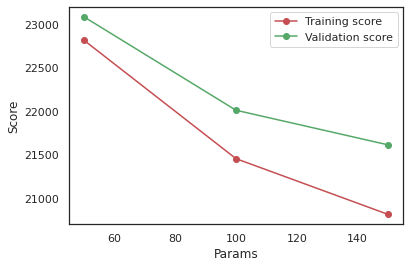

In [ ]:
plot_valscore(xgboost_cv,[50,100,150],scale='linear')

In [ ]:
xgboost_cv.best_score_

-21614.949011227884

When increasing the number of trees on the model, both the training and validation score is decreased. So we increase that parameter continue

##### Set 2

Fine tuning the n_estimators parameter

In [ ]:
xgboost_set2 = xgb.XGBRegressor()
param_xgb_set2 = {'n_estimators':[150,200,250]}
xgboost_cv_set2 = GridSearchCV(estimator=xgboost_set2,param_grid=param_xgb_set2,cv=5,scoring="neg_root_mean_squared_error",return_train_score=True)
xgboost_cv_set2.fit(X_train,y_train)

[08:41:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:41:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:42:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:43:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:44:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:45:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:46:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:47:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'n_estimators': [150, 200, 250]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True

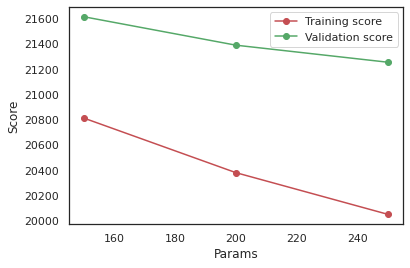

In [ ]:
plot_valscore(xgboost_cv_set2,[150,200,250],scale='linear')

In [ ]:
xgboost_cv_set2.best_score_

-21255.184783995865

The model tends to be overfitting when the number of trees is large

#### Set 3

Fine tuning the learning_rate parameter

In [ ]:
xgboost_set3= xgb.XGBRegressor(n_estimators=250)
param_xgb_set3 = {'learning_rate':[0.1,0.2,0.3]}
xgboost_cv_set3 = GridSearchCV(estimator=xgboost_set3,param_grid=param_xgb_set3,cv=5,scoring="neg_root_mean_squared_error",return_train_score=True)
xgboost_cv_set3.fit(X_train,y_train)

[12:26:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:27:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:29:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:30:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:31:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:33:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:34:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:35:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=250, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'learning_rate': [0.1, 0.2, 0.3]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=Tru

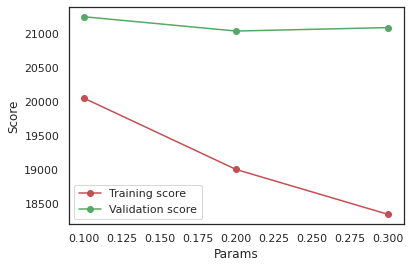

In [ ]:
plot_valscore(xgboost_cv_set3,[0.1,0.2,0.3],scale='linear')

In [ ]:
xgboost_cv_set3.best_score_

-21041.890311095696

The model tends to be overfitting when increasing the value for that parameter

#### Set 4

Due to the model is on overfitting, we will try with the regularization parameter to check whether this parameter can help the model is better?

In [ ]:
xgboost_set4= xgb.XGBRegressor(n_estimators=250,learning_rate=0.2)
param_xgb_set4 = {'reg_alpha':[1e-2,1,1e2]}
xgboost_cv_set4 = GridSearchCV(estimator=xgboost_set4,param_grid=param_xgb_set4,cv=5,scoring="neg_root_mean_squared_error",return_train_score=True)
xgboost_cv_set4.fit(X_train,y_train)

[13:07:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:09:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:10:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:11:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:13:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:14:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:17:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.2,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=250, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'reg_alpha': [0.01, 1, 100.0]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,


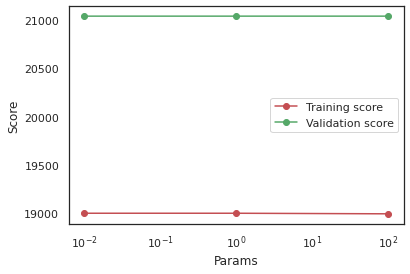

In [ ]:
plot_valscore(xgboost_cv_set4,[1e-2,1,1e2])

That parameter does not affect when changing the value...

#### 6.2.2 Fine tuning for LighGBM parameters

#### Set 1

Fine tuning the n_estimators parameter

In [71]:
lgbm_set1 = lgb.LGBMRegressor()
param_lgbm_set1 = {'n_estimators':[50,100,150]}
lgbm_cv_set1 = GridSearchCV(estimator=lgbm_set1,param_grid=param_lgbm_set1,cv=5,scoring="neg_root_mean_squared_error",return_train_score=True)
lgbm_cv_set1.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, random_state=None,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='deprecated', n_jobs=None,
             param_grid={'n_estimators': [50, 100, 150]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_root_mean_squared_err

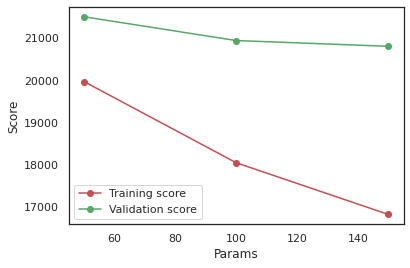

In [72]:
plot_valscore(lgbm_cv_set1,[50,100,150],scale='linear')

In [73]:
lgbm_cv_set1.best_score_

-20805.52964809963

The model tends to be overfitting

#### Set 2

Fine tuning the num_leaves parameter

In [74]:
lgbm_set2 = lgb.LGBMRegressor(n_estimators=150)
param_lgbm_set2 = {'num_leaves':[50,100,150]}
lgbm_cv_set2 = GridSearchCV(estimator=lgbm_set2,param_grid=param_lgbm_set2,cv=5,scoring="neg_root_mean_squared_error",return_train_score=True)
lgbm_cv_set2.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=150, n_jobs=-1, num_leaves=31,
                                     objective=None, random_state=None,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='deprecated', n_jobs=None,
             param_grid={'num_leaves': [50, 100, 150]}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score=True,
             scoring='neg_root_mean_squared_error

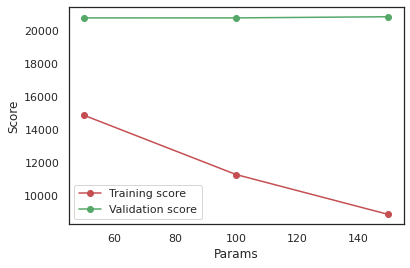

In [75]:
plot_valscore(lgbm_cv_set2,[50,100,150],scale='linear')

In [76]:
lgbm_cv_set2.best_score_

-20794.534347390472

The validation score does not decrease, so the model goes worse when increasing that parameter

#### Set 3

Fine tuning the learning_rate parameter

In [77]:
lgbm_set3 = lgb.LGBMRegressor(n_estimators=150,num_leaves=50)
param_lgbm_set3 = {'learning_rate':[0.03,0.05,0.1]}
lgbm_cv_set3 = GridSearchCV(estimator=lgbm_set3,param_grid=param_lgbm_set3,cv=5,scoring="neg_root_mean_squared_error",return_train_score=True)
lgbm_cv_set3.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=150, n_jobs=-1, num_leaves=50,
                                     objective=None, random_state=None,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='deprecated', n_jobs=None,
             param_grid={'learning_rate': [0.03, 0.05, 0.1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_root_mean_squared

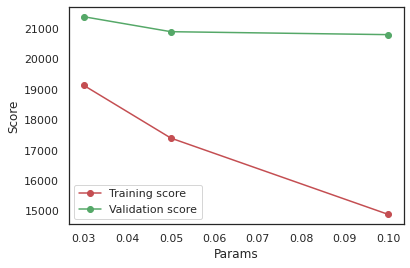

In [78]:
plot_valscore(lgbm_cv_set3,[0.03,0.05,0.1],scale='linear')

In [79]:
lgbm_cv_set3.best_score_

-20794.534347390472

#### Set 4

Fine tuning max_depth parameter

In [80]:
lgbm_set4 = lgb.LGBMRegressor(n_estimators=150,num_leaves=50,learning_rate=0.1)
param_lgbm_set4= {'max_depth':[5,7,10]}
lgbm_cv_set4 = GridSearchCV(estimator=lgbm_set4,param_grid=param_lgbm_set4,cv=5,scoring="neg_root_mean_squared_error",return_train_score=True)
lgbm_cv_set4.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=150, n_jobs=-1, num_leaves=50,
                                     objective=None, random_state=None,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [5, 7, 10]}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score=True,
             scoring='neg_root_mean_squared_error', ve

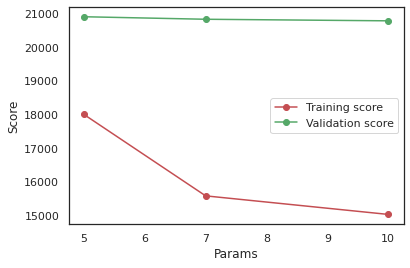

In [82]:
plot_valscore(lgbm_cv_set4,[5,7,10],scale='linear')

In [83]:
lgbm_cv_set4.best_score_

-20782.86712591542

In [84]:
lgbm_cv_set4.best_params_

{'max_depth': 10}

The validation score is reducing very slightly but the training score decrease too much, the model is overfitting

### 6.3 Voting

Both XGBoost and LighGBM is generating a better score on validation but make the model slightly overfitting. Ridge and Lasso look like poor performance on this dataset. So we chose two the boosting model for voting the final result

In [85]:
r1 = xgb.XGBRegressor(n_estimators=250,learning_rate=0.2)
r2 = lgb.LGBMRegressor(n_estimators=150,num_leaves=50,learning_rate=0.1, max_depth=10)
regressor = VotingRegressor([('xgb', r1), ('lgb', r2)]).fit(X_train,y_train)

[08:13:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


# Submit

In [86]:
def to_submit_file(file_name, probs):
    """
    A helper function helps generating submit files
    
    :param file_name: submit file name
    :param probs: list of probabilities for test samples
    
    :return: None
    """
    submit = test_id.copy()
    submit['Salary'] = probs
    submit.to_csv(file_name, index = False)
    print ('Done writting submit file: ', file_name)

In [87]:
test_id = pd.read_csv('/content/gdrive/My Drive/Python/Final project/Predict Engineer salary/data_all/submit.csv')

In [88]:
y_pred = regressor.predict(X_test)

In [89]:
to_submit_file('xgb-lgb-voting.csv',y_pred)

Done writting submit file:  xgb-lgb-voting.csv
